#Set-up enviroment

In [ ]:
!rm -r sample_data/

In [ ]:
#Download Kaggle dataset guide: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle   
!mv ./kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Saving kaggle.json to kaggle.json
100% 5.20G/5.20G [02:05<00:00, 51.0MB/s]
100% 5.20G/5.20G [02:05<00:00, 44.6MB/s]


In [ ]:
!mkdir data 
!unzip skin-cancer-mnist-ham10000.zip -d data
!mv data/HAM10000_metadata.csv ./HAM10000_metadata.csv
!rm -r data/ham10000_images_part_1 data/ham10000_images_part_2 data/*.csv
!mkdir weights grid logs

Librerie

In [ ]:
import os
import cv2
import sys
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy

Path

In [ ]:
root = './'
data_path = os.path.join(root, "data")
weights_path = os.path.join(root, 'weights')
grid_path = os.path.join(root, 'grid')
logs_path = os.path.join(root, 'logs')

#Dataset

Histogram

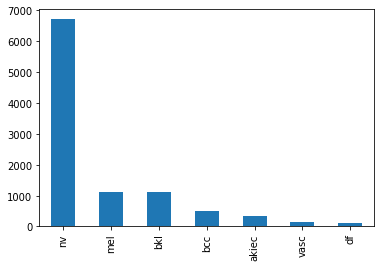

In [ ]:
df = pd.read_csv ('HAM10000_metadata.csv', sep=',')
df['dx'].value_counts().plot(kind='bar')

TFrecord

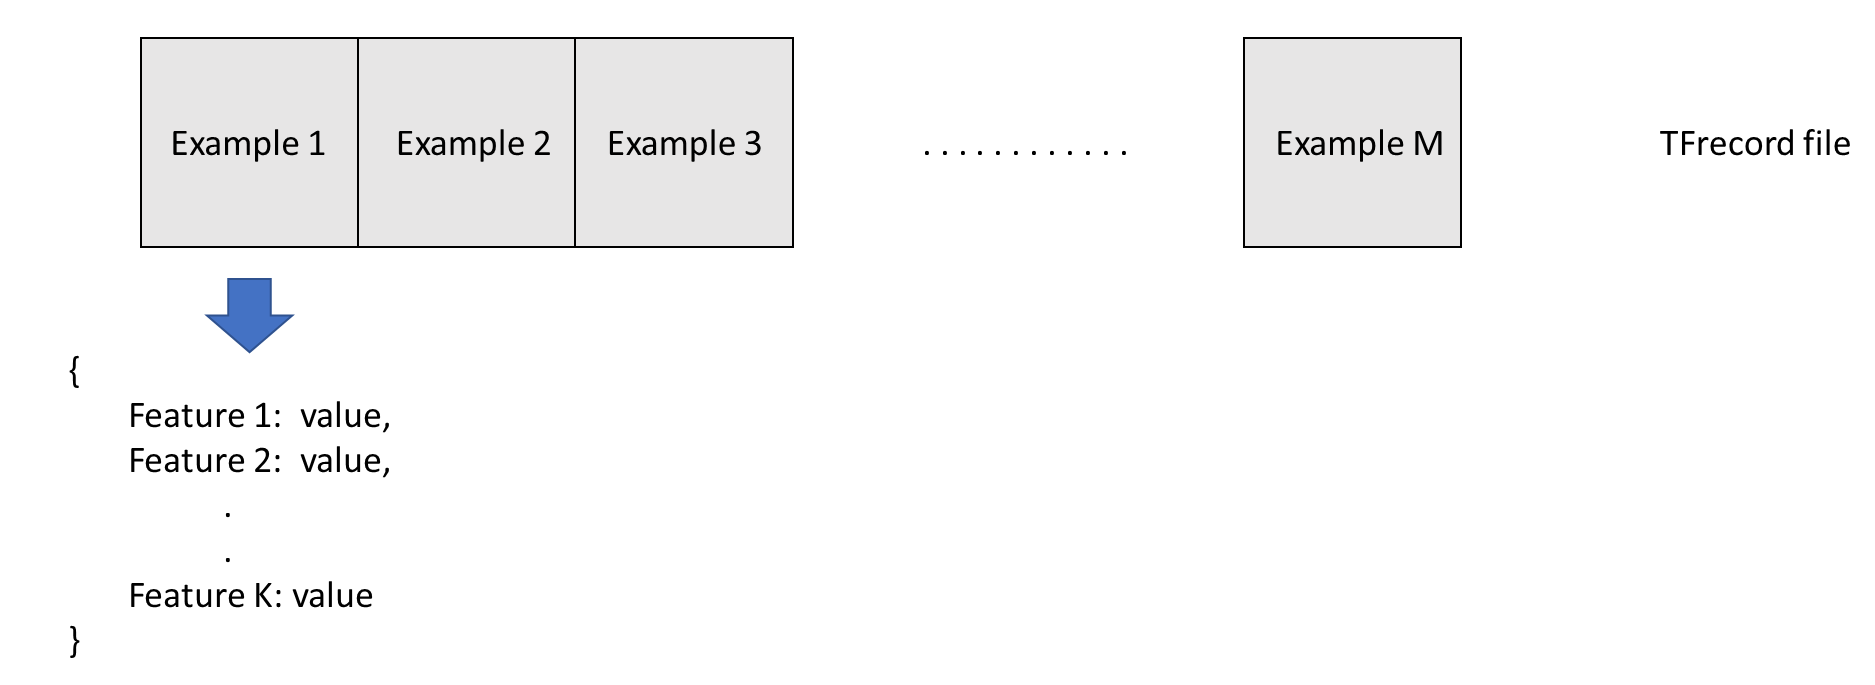

In [ ]:
#Based on: https://www.tensorflow.org/tutorials/load_data/tfrecord
def bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def format_example(name_img, img):
  example = tf.train.Example(features=tf.train.Features(feature={

    'image_name': bytes_feature(name_img.encode('utf-8')),  
    'image_raw': bytes_feature(img.tobytes()), 

    'image_format': bytes_feature('jpg'.encode('utf-8')),
    'image_height': int64_feature(img.shape[0]),
    'image_width': int64_feature(img.shape[1]),

  }))

  return example

In [ ]:
name_dataset = os.path.join(root, "Skin_cancer.tfrecord")
tfrecord_writer = tf.compat.v1.python_io.TFRecordWriter(name_dataset)
len_dataset = 0

for dir in os.listdir(data_path):
  for name_img in os.listdir(os.path.join(data_path, dir)):
    len_dataset += 1
    img = cv2.imread(os.path.join(data_path, dir, name_img), 1)
    img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_NEAREST).reshape(64, 64, 3)

    example = format_example(name_img,img)
    tfrecord_writer.write(example.SerializeToString())
    sys.stdout.write("\r<Creazione TFrecord> Analisi: " + str(len_dataset))
    sys.stdout.flush()

tfrecord_writer.close()

<Creazione TFrecord> Analisi: 10015

In [ ]:
descriptor_dataset = {
  'image_name': tf.io.FixedLenFeature([], tf.string), 
  'image_raw': tf.io.FixedLenFeature([], tf.string), 
  'image_format': tf.io.FixedLenFeature((), tf.string),  # .png/.jpg
  'image_height': tf.io.FixedLenFeature([], tf.int64, default_value=64),
  'image_width': tf.io.FixedLenFeature([], tf.int64, default_value=64),
  }

#GAN

In [ ]:
def build_generator(latent_size):
  model = Sequential()

  # Input
  model.add(Dense(4 * 4 * 256, activation="relu", input_shape=(latent_size,)))
  model.add(Reshape((4, 4, 256))) #[batch,4,4,256]
  
  # block_1
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu")) #[batch,8,8,256]

  # block_2
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu")) #[batch,16,16,256]

  # block_3
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu")) #[batch,32,32,128]

  # block_4
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu")) #[batch,64,64,128]

  # Output
  model.add(Conv2D(3, kernel_size=3, padding="same"))
  model.add(Activation('tanh')) #[batch,64,64,3]

  return model

In [ ]:
def build_discriminator(input_size):
  model = Sequential()

  # block_1
  model.add(Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', data_format="channels_last", input_shape=input_size))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2)) #[batch,32,32,64]

  # block_2
  model.add(Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', data_format="channels_last"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2)) #[batch,16,16,128]

  # block_3
  model.add(Conv2D(256, kernel_size=(3, 3), strides=2, padding='same', data_format="channels_last"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2)) #[batch,8,8,256]

  # block_4
  model.add(Conv2D(512, kernel_size=(3, 3), strides=1, padding='same', data_format="channels_last"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2)) #[batch,8,8,512]

  # output
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid')) #[batch,1]

  return model


In [ ]:
def generator_loss(fake_output):
  return tf.reduce_mean(BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output))

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = tf.reduce_mean(BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output))
  fake_loss = tf.reduce_mean(BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output))
  total_loss = (real_loss + fake_loss)
  return total_loss

#Utils

In [ ]:
def make_grid(tensor, nrow=8, padding=2,
              normalize=False, scale_each=False):
  """Code based on https://github.com/pytorch/vision/blob/master/torchvision/utils.py"""
  nmaps = tensor.shape[0]
  xmaps = min(nrow, nmaps)  
  ymaps = int(math.ceil(float(nmaps) / xmaps)) 
  height, width = int(tensor.shape[1] + padding), int(tensor.shape[2] + padding)
  grid = np.zeros([height * ymaps + 1 + padding // 2, width * xmaps + 1 + padding // 2, 3], dtype=np.uint8)
  k = 0
  for y in range(ymaps):
      for x in range(xmaps):
          if k >= nmaps:
              break
          h, h_width = y * height + 1 + padding // 2, height - padding
          w, w_width = x * width + 1 + padding // 2, width - padding

          grid[h:h + h_width, w:w + w_width] = tensor[k]
          k = k + 1
  return grid
  
def save_image(tensor, filename, nrow=8, padding=2,
               normalize=False, scale_each=False):
  ndarr = make_grid(tensor, nrow=nrow, padding=padding,
                    normalize=normalize, scale_each=scale_each)
  cv2.imwrite(filename, ndarr)

In [ ]:
def preprocessamento(example_proto):
  example = tf.io.parse_single_example(example_proto, descriptor_dataset)

  w = example['image_width']
  h = example['image_height']
  image_raw = tf.reshape(tf.io.decode_raw(example['image_raw'], tf.uint8), [w, h, 3])
  image_raw = tf.cast(image_raw, dtype=tf.float32)
  image_raw_prepr = tf.math.divide(tf.math.subtract(image_raw, 127.5), 127.5)  #[-1,1]

  return image_raw_prepr

#Training

In [ ]:
def train_on_batch(generator, generator_optimizer,
                   discriminator, discriminator_optimizer,
                   noise_batch, real_imgs_batch):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_imgs_batch = generator(noise_batch) # Generator create the image

    real_output = discriminator(real_imgs_batch) # Prediction on real
    fake_output = discriminator(fake_imgs_batch) # Prediction on generated

    # Loss
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Thanks to the subdivision of the optimizers we can train simultaneously 
  # the generator and the discriminator
  discriminator_optimizer.minimize(disc_loss, var_list=discriminator.trainable_weights, tape=disc_tape)
  generator_optimizer.minimize(gen_loss, var_list=generator.trainable_weights, tape=gen_tape)
  
  return gen_loss, disc_loss, real_output, fake_output, fake_imgs_batch

In [ ]:
# -1.Training params
input_size = [64, 64, 3]
g_lr = 0.0001
d_lr = 0.0002
latent_size = 100
batch_size = 32
epochs = 50
num_batches = len_dataset // batch_size

# -2.Callbacks
# --end epoch
save_weights_epoch = 1
# --end iteration
save_grid_iteration = 50

#######################################################################

# Pipeline: Load dataset
dataset = tf.data.TFRecordDataset(name_dataset)
dataset = dataset.map(preprocessamento, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(len_dataset, reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# Build GAN
generator = build_generator(latent_size)
generator_optimizer = tf.keras.optimizers.RMSprop(lr=g_lr, decay=3e-8)
#generator_optimizer = tf.keras.optimizers.Adam(lr=0.000002)

discriminator = build_discriminator(input_size)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=d_lr, decay=6e-8)
#discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.000004)

# Metrics
metric_accuracy_real = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5)
metric_accuracy_fake = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5)

history = {"epoch": 0,
            "loss_G": [],
            "loss_D": [],
            "acc_real": [],
            "acc_fake": []
            }

# Training
for epoch in range(epochs):

  dataset_iterator = iter(dataset)
  array_gen_loss = np.empty(num_batches)
  array_disc_loss = np.empty(num_batches)
  metric_accuracy_real.reset_state()
  metric_accuracy_fake.reset_state()

  name_dir_grid = os.path.join(grid_path, str(epoch + 1))
  if not os.path.exists(name_dir_grid):
    os.mkdir(name_dir_grid)

  for step in range(num_batches):
    noise_batch = tf.random.normal(mean=0.0, stddev=1.0, shape=[batch_size, latent_size], dtype=tf.float32)
    real_imgs_batch = next(dataset_iterator)

    array_gen_loss[step], array_disc_loss[step], \
    real, fake, fake_imgs_batch = train_on_batch(generator, generator_optimizer,
                                                  discriminator, discriminator_optimizer,
                                                  noise_batch, real_imgs_batch)

    # -Callbacks iteration
    # --Metrics
    # [TP/(TP+FP)]
    metric_accuracy_real.update_state(tf.ones_like(real), real)
    accuracy_real = metric_accuracy_real.result().numpy()
    # [TN/(TN+FN)]
    metric_accuracy_fake.update_state(tf.zeros_like(fake), fake)
    accuracy_fake = metric_accuracy_fake.result().numpy()

    # --Logs
    logs = "Epoch {epoch} step {step} / {iterations} --> gen_loss: {gen_loss:.4f}, disc_loss: {disc_loss:.4f}, acc_real:{acc_real:.4f}, acc_fake:{acc_fake:.4f}".format(
        epoch=epoch + 1,
        step=step + 1,
        iterations=len_dataset // batch_size,
        gen_loss=np.mean(array_gen_loss[:step + 1]),
        disc_loss=np.mean(array_disc_loss[:step + 1]),
        acc_real=accuracy_real,
        acc_fake=accuracy_fake
    )
    sys.stdout.write('\r')
    sys.stdout.write(logs)
    sys.stdout.flush()

    # --Save images
    if step % save_grid_iteration == 0:
      save_image((fake_imgs_batch * 127.5) + 127.5, os.path.join(name_dir_grid, "imgs" + str(step) + ".png"),
                    nrow=8)
      
  sys.stdout.write('\n')

  # -Callbacks epoch
  # --Save weights
  if epoch % save_weights_epoch == 0:
    name_generator = "Generator_{epoch}-acc_real_{acc_real}-acc_fake_{acc_fake}.hdf5".format(
        epoch=epoch + 1,
        acc_real=accuracy_real,
        acc_fake=accuracy_fake
    )
    name_discriminator = "Discriminator_{epoch}.hdf5".format(epoch=epoch + 1)
    generator.save_weights(os.path.join(weights_path, name_generator))
    discriminator.save_weights(os.path.join(weights_path, name_discriminator))
  # --History
  history['epoch'] = epoch + 1
  history['loss_G'].append(np.mean(array_gen_loss))
  history['loss_D'].append(np.mean(array_disc_loss))
  history['acc_real'].append(accuracy_real)
  history['acc_fake'].append(accuracy_fake)
  np.save(os.path.join(logs_path,'history.npy'), history)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1 step 312 / 312 --> gen_loss: 0.8882, disc_loss: 1.2660, acc_real:0.6354, acc_fake:0.6433
Epoch 2 step 312 / 312 --> gen_loss: 1.0059, disc_loss: 1.2510, acc_real:0.6333, acc_fake:0.6574
Epoch 3 step 312 / 312 --> gen_loss: 0.9920, disc_loss: 1.2344, acc_real:0.6505, acc_fake:0.6825
Epoch 4 step 312 / 312 --> gen_loss: 1.2468, disc_loss: 1.1242, acc_real:0.6998, acc_fake:0.7598
Epoch 5 step 312 / 312 --> gen_loss: 1.3284, disc_loss: 1.0456, acc_real:0.7052, acc_fake:0.8002
Epoch 6 step 312 / 312 --> gen_loss: 1.4382, disc_loss: 1.0317, acc_real:0.7260, acc_fake:0.8021
Epoch 7 step 312 / 312 --> gen_loss: 1.4545, disc_loss: 0.9881, acc_real:0.7304, acc_fake:0.8182
Epoch 8 step 312 / 312 --> gen_loss: 1.5944, disc_loss: 0.9491, acc_real:0.7472, acc_fake:0.8195
Epoch 9 step 312 / 312 --> gen_loss: 1.7582, disc_loss: 0.8568, acc_real:0.7696, acc_fake:0.8495
Epoch 10 step 312 / 312 --> gen_loss: 1.7740, disc_loss: 0.8853, acc_real:0.7736, acc_fake:0.8602
Epoch 11 step 312 / 312 --> g

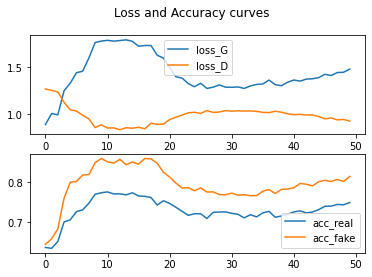

In [ ]:
import matplotlib.pyplot as plt

history = np.load(os.path.join(logs_path,"history.npy"), allow_pickle=True)

fig, axs = plt.subplots(2)
fig.suptitle('Loss and Accuracy curves')

axs[0].plot(history[()]['loss_G'], label='loss_G')
axs[0].plot(history[()]['loss_D'], label='loss_D')
axs[0].legend()

axs[1].plot(history[()]['acc_real'], label='acc_real')
axs[1].plot(history[()]['acc_fake'], label='acc_fake')
axs[1].legend()

plt.show()


In [ ]:
!zip weights.zip weights/* grid/*/* logs/*

#Inference

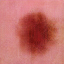

In [ ]:
from google.colab.patches import cv2_imshow

input_size = [64, 64, 3]
latent_size = 100
batch_size = 1
name_weights = "Generator_40-acc_real_0.7193509340286255-acc_fake_0.7830528616905212.hdf5"

generator = build_generator(latent_size)
generator.load_weights(os.path.join(weights_path, name_weights))

noise_batch = tf.random.normal(mean=0.0, stddev=1.0, shape=[batch_size, latent_size], dtype=tf.float32)
prediction = generator.predict(noise_batch)
prediction = (prediction[0] * 127.5) + 127.5
prediction = prediction.astype(dtype=np.uint8)

cv2_imshow(prediction)